In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
df = pd.read_csv('googleplaystore.csv')



In [2]:
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [5]:
i = df[df['Category'] == '1.9'].index
df.loc[i]
df = df.drop(i)

In [6]:
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

In [7]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [8]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [9]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [10]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [11]:
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [12]:
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [13]:
df['Type'] = pd.get_dummies(df['Type'])

In [14]:
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [15]:
df['Size'] = df['Size'].apply(lambda x: x.strip('M').strip('k'))
df[df['Size'] == 'Varies with device'] = 0

In [16]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [19]:
model = KNeighborsRegressor(n_neighbors=15)

In [20]:
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

In [21]:
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 92.23%'

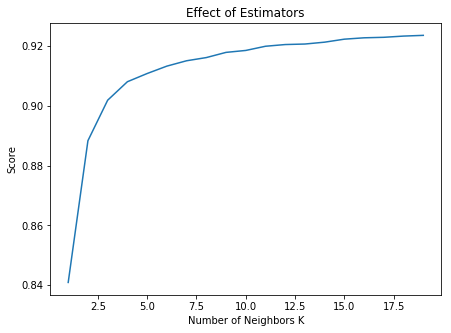

In [22]:
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

[(10, 0.9323346180194131),
 (20, 0.9332945813035154),
 (30, 0.9359914782394954),
 (40, 0.9369476962475211),
 (50, 0.936183248253913),
 (60, 0.9358810538772826),
 (70, 0.9369914491061065),
 (80, 0.9375746829954921),
 (90, 0.9367368329617984),
 (100, 0.9383698511594503),
 (110, 0.9379328625832202),
 (120, 0.9379355588725009),
 (130, 0.9383491330513438),
 (140, 0.9377966091689373),
 (150, 0.9379696217184449),
 (160, 0.9378281691625572),
 (170, 0.9378406189096089),
 (180, 0.937458465114336),
 (190, 0.9380090470994444)]

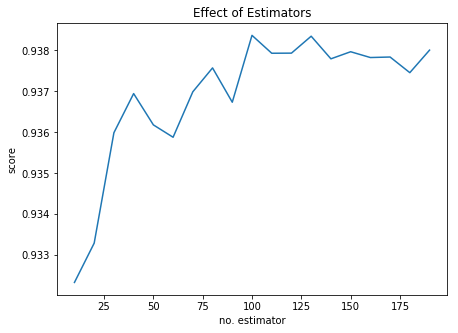

In [23]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results